# Diagnosis Data Preprocessing

This notebook processes clinician consensus diagnoses from HBN dataset and creates binary flags for key diagnostic categories.

**Analysis Pipeline:**
1. Load and inspect diagnosis data
2. Clean participant IDs
3. Analyze diagnosis structure (Cat/Sub/specific labels)
4. Create diagnostic flags (Neurodevelopmental, Anxiety)
5. Validate and save results
6. Visualize diagnostic patterns

**Key Diagnosis Fields:**
- `DX_##_Cat`: DSM-5 category (e.g., "Anxiety Disorders", "Neurodevelopmental Disorders")
- `DX_##_Sub`: Subcategory (e.g., "ADHD", "Autism Spectrum Disorder")
- `DX_##`: Specific diagnosis label (e.g., "Generalized Anxiety Disorder")

## 1. Setup

In [77]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

# Plotting style
plt.rcParams['figure.dpi'] = 160
sns.set_style("whitegrid")
sns.set_context("notebook")

print("✓ Libraries loaded")

✓ Libraries loaded


In [78]:
# Set up paths
DATA_DIR = Path("data")
RESULTS_DIR = Path("results/diagnosis_figures")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Results directory: {RESULTS_DIR.absolute()}")

Data directory: /Users/yizj/Desktop/hbn_project/data
Results directory: /Users/yizj/Desktop/hbn_project/results/diagnosis_figures


## 2. Load Data

In [79]:
# Load diagnosis data
diag_path = DATA_DIR / "interim" / "HBN_pheno_with_diagnosis.csv"
diag = pd.read_csv(diag_path)

print(f"Loaded: {diag.shape[0]} participants, {diag.shape[1]} columns")
print(f"\nColumn overview:")
diag.info()

Loaded: 3373 participants, 174 columns

Column overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Columns: 174 entries, EID to Diagnosis_ClinicianConsensus,Year
dtypes: float64(98), int64(14), object(62)
memory usage: 4.5+ MB


## 3. Identify Diagnosis Columns

In [80]:
# Identify all diagnosis columns (up to 10 diagnoses per participant)
dx_cat_cols = [
    f"Diagnosis_ClinicianConsensus,DX_{i:02d}_Cat" 
    for i in range(1, 11)
]

dx_sub_cols = [
    f"Diagnosis_ClinicianConsensus,DX_{i:02d}_Sub" 
    for i in range(1, 11)
]

# Keep only columns that exist
dx_cat_cols = [c for c in dx_cat_cols if c in diag.columns]
dx_sub_cols = [c for c in dx_sub_cols if c in diag.columns]

print(f"Found {len(dx_cat_cols)} category columns")
print(f"Found {len(dx_sub_cols)} subcategory columns")

Found 10 category columns
Found 10 subcategory columns


## 4. Clean Participant IDs

In [81]:
# Standardize ID columns
if "_EID" in diag.columns:
    diag["_EID"] = diag["_EID"].astype(str).str.upper().str.strip()

if "EID" in diag.columns:
    diag["EID"] = diag["EID"].astype(str).str.upper().str.strip()
    
    # Check for mismatches
    if "_EID" in diag.columns:
        mask_both = diag[["EID", "_EID"]].notna().all(axis=1)
        mismatch = diag.loc[mask_both & (diag["EID"] != diag["_EID"]), ["EID", "_EID"]]
        print(f"ID mismatches after cleaning: {len(mismatch)}")
    
    # Drop redundant ID columns
    diag = diag.drop(columns=["EID"], errors="ignore")

# Drop other ID variants
diag = diag.drop(columns=["ï»¿EID", "Identifiers"], errors="ignore")

print(f"✓ ID columns cleaned")
print(f"  Using '_EID' as primary identifier")
print(f"  Unique participants: {diag['_EID'].nunique()}")

ID mismatches after cleaning: 0
✓ ID columns cleaned
  Using '_EID' as primary identifier
  Unique participants: 3373


## 5. Analyze Diagnosis Structure

### 5.1 Missingness Across Diagnosis Slots

In [82]:
# Analyze missingness
dx_cols = dx_cat_cols + dx_sub_cols
missing_frac = diag[dx_cols].isna().mean().sort_values(ascending=False)
n_unique = diag[dx_cols].nunique(dropna=True).loc[missing_frac.index]

summary = pd.DataFrame({
    "missing_%": (missing_frac * 100).round(1),
    "n_unique": n_unique
})

print("Diagnosis column summary:")
print(summary.head(10))
print("\nInterpretation: Later slots (DX_02+) are mostly NA because most participants have only 1-2 diagnoses.")

Diagnosis column summary:
                                        missing_%  n_unique
Diagnosis_ClinicianConsensus,DX_10_Sub       99.9         2
Diagnosis_ClinicianConsensus,DX_10_Cat       99.9         3
Diagnosis_ClinicianConsensus,DX_09_Sub       99.8         3
Diagnosis_ClinicianConsensus,DX_09_Cat       99.7         3
Diagnosis_ClinicianConsensus,DX_08_Sub       99.6         4
Diagnosis_ClinicianConsensus,DX_08_Cat       99.2         7
Diagnosis_ClinicianConsensus,DX_07_Sub       98.9         6
Diagnosis_ClinicianConsensus,DX_07_Cat       97.8         8
Diagnosis_ClinicianConsensus,DX_06_Sub       97.2         7
Diagnosis_ClinicianConsensus,DX_06_Cat       94.6        12

Interpretation: Later slots (DX_02+) are mostly NA because most participants have only 1-2 diagnoses.


### 5.2 Category Distribution

In [83]:
# Get all categories across all slots
all_cats = pd.concat([diag[col].dropna() for col in dx_cat_cols], ignore_index=True)
cat_counts = all_cats.value_counts()

print("\nTop diagnostic categories:")
print(cat_counts.head(10))


Top diagnostic categories:
Neurodevelopmental Disorders                                  4432
Anxiety Disorders                                             1527
Disruptive, Impulse Control and Conduct Disorders              530
Depressive Disorders                                           355
Elimination Disorders                                          319
No Diagnosis Given                                             303
No Diagnosis Given: Incomplete Eval                            213
Trauma and Stressor Related Disorders                          160
Obsessive Compulsive and Related Disorders                     155
Other Conditions That May Be a Focus of Clinical Attention      48
Name: count, dtype: int64


### 5.3 Category-Subcategory Mapping

In [84]:
# Build long-form diagnosis data
rows = []
for cat_col in dx_cat_cols:
    slot = cat_col.split("DX_")[1].split("_Cat")[0]
    sub_col = cat_col.replace("_Cat", "_Sub")
    if sub_col not in diag.columns:
        continue
    
    tmp = diag[[cat_col, sub_col]].copy()
    tmp.columns = ["Cat", "Sub"]
    tmp["slot"] = slot
    rows.append(tmp)

dx_long = pd.concat(rows, ignore_index=True)

# Count Cat-Sub combinations
mapping_counts = (
    dx_long
    .dropna(subset=["Cat", "Sub"])
    .groupby(["Cat", "Sub"])
    .size()
    .reset_index(name="n")
    .sort_values(["Cat", "n"], ascending=[True, False])
)

print("\nCategory-Subcategory mappings (top 20):")
print(mapping_counts.head(20))


Category-Subcategory mappings (top 20):
                                                  Cat  \
0                                   Anxiety Disorders   
1                                   Anxiety Disorders   
2                                Depressive Disorders   
3                                Depressive Disorders   
4                                Depressive Disorders   
5                               Elimination Disorders   
6                        Neurodevelopmental Disorders   
12                       Neurodevelopmental Disorders   
8                        Neurodevelopmental Disorders   
7                        Neurodevelopmental Disorders   
10                       Neurodevelopmental Disorders   
9                        Neurodevelopmental Disorders   
11                       Neurodevelopmental Disorders   
13                                 No Diagnosis Given   
14                No Diagnosis Given: Incomplete Eval   
16  Other Conditions That May Be a Focus of Cli

In [85]:
# Focus on key categories
print("\n=== Neurodevelopmental Disorders ===")
neuro_map = mapping_counts[mapping_counts["Cat"] == "Neurodevelopmental Disorders"]
print(neuro_map)

print("\n=== Anxiety Disorders ===")
anx_map = mapping_counts[mapping_counts["Cat"] == "Anxiety Disorders"]
if len(anx_map) == 0:
    print("No Cat-Sub mappings (Sub field mostly empty for Anxiety)")
else:
    print(anx_map)


=== Neurodevelopmental Disorders ===
                             Cat                                       Sub  \
6   Neurodevelopmental Disorders  Attention-Deficit/Hyperactivity Disorder   
12  Neurodevelopmental Disorders                Specific Learning Disorder   
8   Neurodevelopmental Disorders                    Communication Disorder   
7   Neurodevelopmental Disorders                  Autism Spectrum Disorder   
10  Neurodevelopmental Disorders                            Motor Disorder   
9   Neurodevelopmental Disorders                   Intellectual Disability   
11  Neurodevelopmental Disorders        Other Neurodevelopmental Disorders   

       n  
6   1989  
12  1023  
8    549  
7    523  
10   262  
9     81  
11     4  

=== Anxiety Disorders ===
                 Cat                         Sub  n
0  Anxiety Disorders      Communication Disorder  2
1  Anxiety Disorders  Specific Learning Disorder  1


**Key Finding**: 
- Neurodevelopmental disorders have well-populated subcategories (ADHD, ASD, SLD)
- Anxiety disorders have minimal subcategory data → use Cat-level flag only

## 6. Create Diagnosis Flags

In [86]:
# Initialize flags dataframe
diag_flags = diag[["_EID"]].copy()

# Broad category flags
diag_flags["dx_neuro_any"] = (
    diag[dx_cat_cols]
    .eq("Neurodevelopmental Disorders")
    .any(axis=1)
    .astype(int)
)

diag_flags["dx_anx_any"] = (
    diag[dx_cat_cols]
    .eq("Anxiety Disorders")
    .any(axis=1)
    .astype(int)
)

# Specific neurodevelopmental flags from subcategories
diag_flags["dx_adhd_any"] = (
    diag[dx_sub_cols]
    .eq("Attention-Deficit/Hyperactivity Disorder")
    .any(axis=1)
    .astype(int)
)

diag_flags["dx_asd_any"] = (
    diag[dx_sub_cols]
    .eq("Autism Spectrum Disorder")
    .any(axis=1)
    .astype(int)
)

diag_flags["dx_sld_any"] = (
    diag[dx_sub_cols]
    .eq("Specific Learning Disorder")
    .any(axis=1)
    .astype(int)
)

print("✓ Created diagnosis flags")
diag_flags.head()

✓ Created diagnosis flags


,_EID,dx_neuro_any,dx_anx_any,dx_adhd_any,dx_asd_any,dx_sld_any
0,NDARAA075AMK,0,0,0,0,0
1,NDARAA112DMH,1,0,1,0,0
2,NDARAA117NEJ,1,0,1,0,0
3,NDARAA306NT2,1,1,1,0,1
4,NDARAA504CRN,1,1,1,0,1


### 6.1 Validate Flag Consistency

In [87]:
# Check: dx_neuro_any should cover all specific ND flags
specific_nd = diag_flags[["dx_adhd_any", "dx_asd_any", "dx_sld_any"]].max(axis=1)
inconsistent = (diag_flags["dx_neuro_any"] == 0) & (specific_nd == 1)

print(f"Inconsistent cases (specific ND=1 but neuro_any=0): {inconsistent.sum()}")

if inconsistent.sum() > 0:
    # Fix inconsistencies
    diag_flags.loc[inconsistent, "dx_neuro_any"] = 1
    print("✓ Fixed inconsistencies")

# Verify
assert (diag_flags["dx_neuro_any"] >= specific_nd).all(), "Validation failed!"
print("✓ Validation passed: dx_neuro_any covers all specific ND flags")

Inconsistent cases (specific ND=1 but neuro_any=0): 1
✓ Fixed inconsistencies
✓ Validation passed: dx_neuro_any covers all specific ND flags


### 6.2 Summary Statistics

In [88]:
# Prevalence counts
flag_cols = ["dx_neuro_any", "dx_adhd_any", "dx_asd_any", "dx_sld_any", "dx_anx_any"]
prevalence = diag_flags[flag_cols].sum()
prevalence_pct = (prevalence / len(diag_flags) * 100).round(1)

summary_stats = pd.DataFrame({
    "N": prevalence,
    "Prevalence_%": prevalence_pct
})

print("\nDiagnosis prevalence:")
print(summary_stats)
print(f"\nTotal participants: {len(diag_flags)}")


Diagnosis prevalence:
                 N  Prevalence_%
dx_neuro_any  2503          74.2
dx_adhd_any   1985          58.8
dx_asd_any     518          15.4
dx_sld_any     746          22.1
dx_anx_any    1072          31.8

Total participants: 3373


## 7. Save Results

In [89]:
# Save diagnosis flags
out_path = DATA_DIR / "processed" / "hbn_diag_flags_neuro_anx.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
diag_flags.to_csv(out_path, index=False)

print(f"✓ Saved diagnosis flags: {out_path}")
print(f"  Rows: {len(diag_flags)}")
print(f"  Columns: {list(diag_flags.columns)}")

✓ Saved diagnosis flags: data/processed/hbn_diag_flags_neuro_anx.csv
  Rows: 3373
  Columns: ['_EID', 'dx_neuro_any', 'dx_anx_any', 'dx_adhd_any', 'dx_asd_any', 'dx_sld_any']


## 8. Visualizations

Generate high-quality figures (300 DPI) for understanding diagnostic patterns.

### 8.1 Diagnosis Prevalence Bar Chart

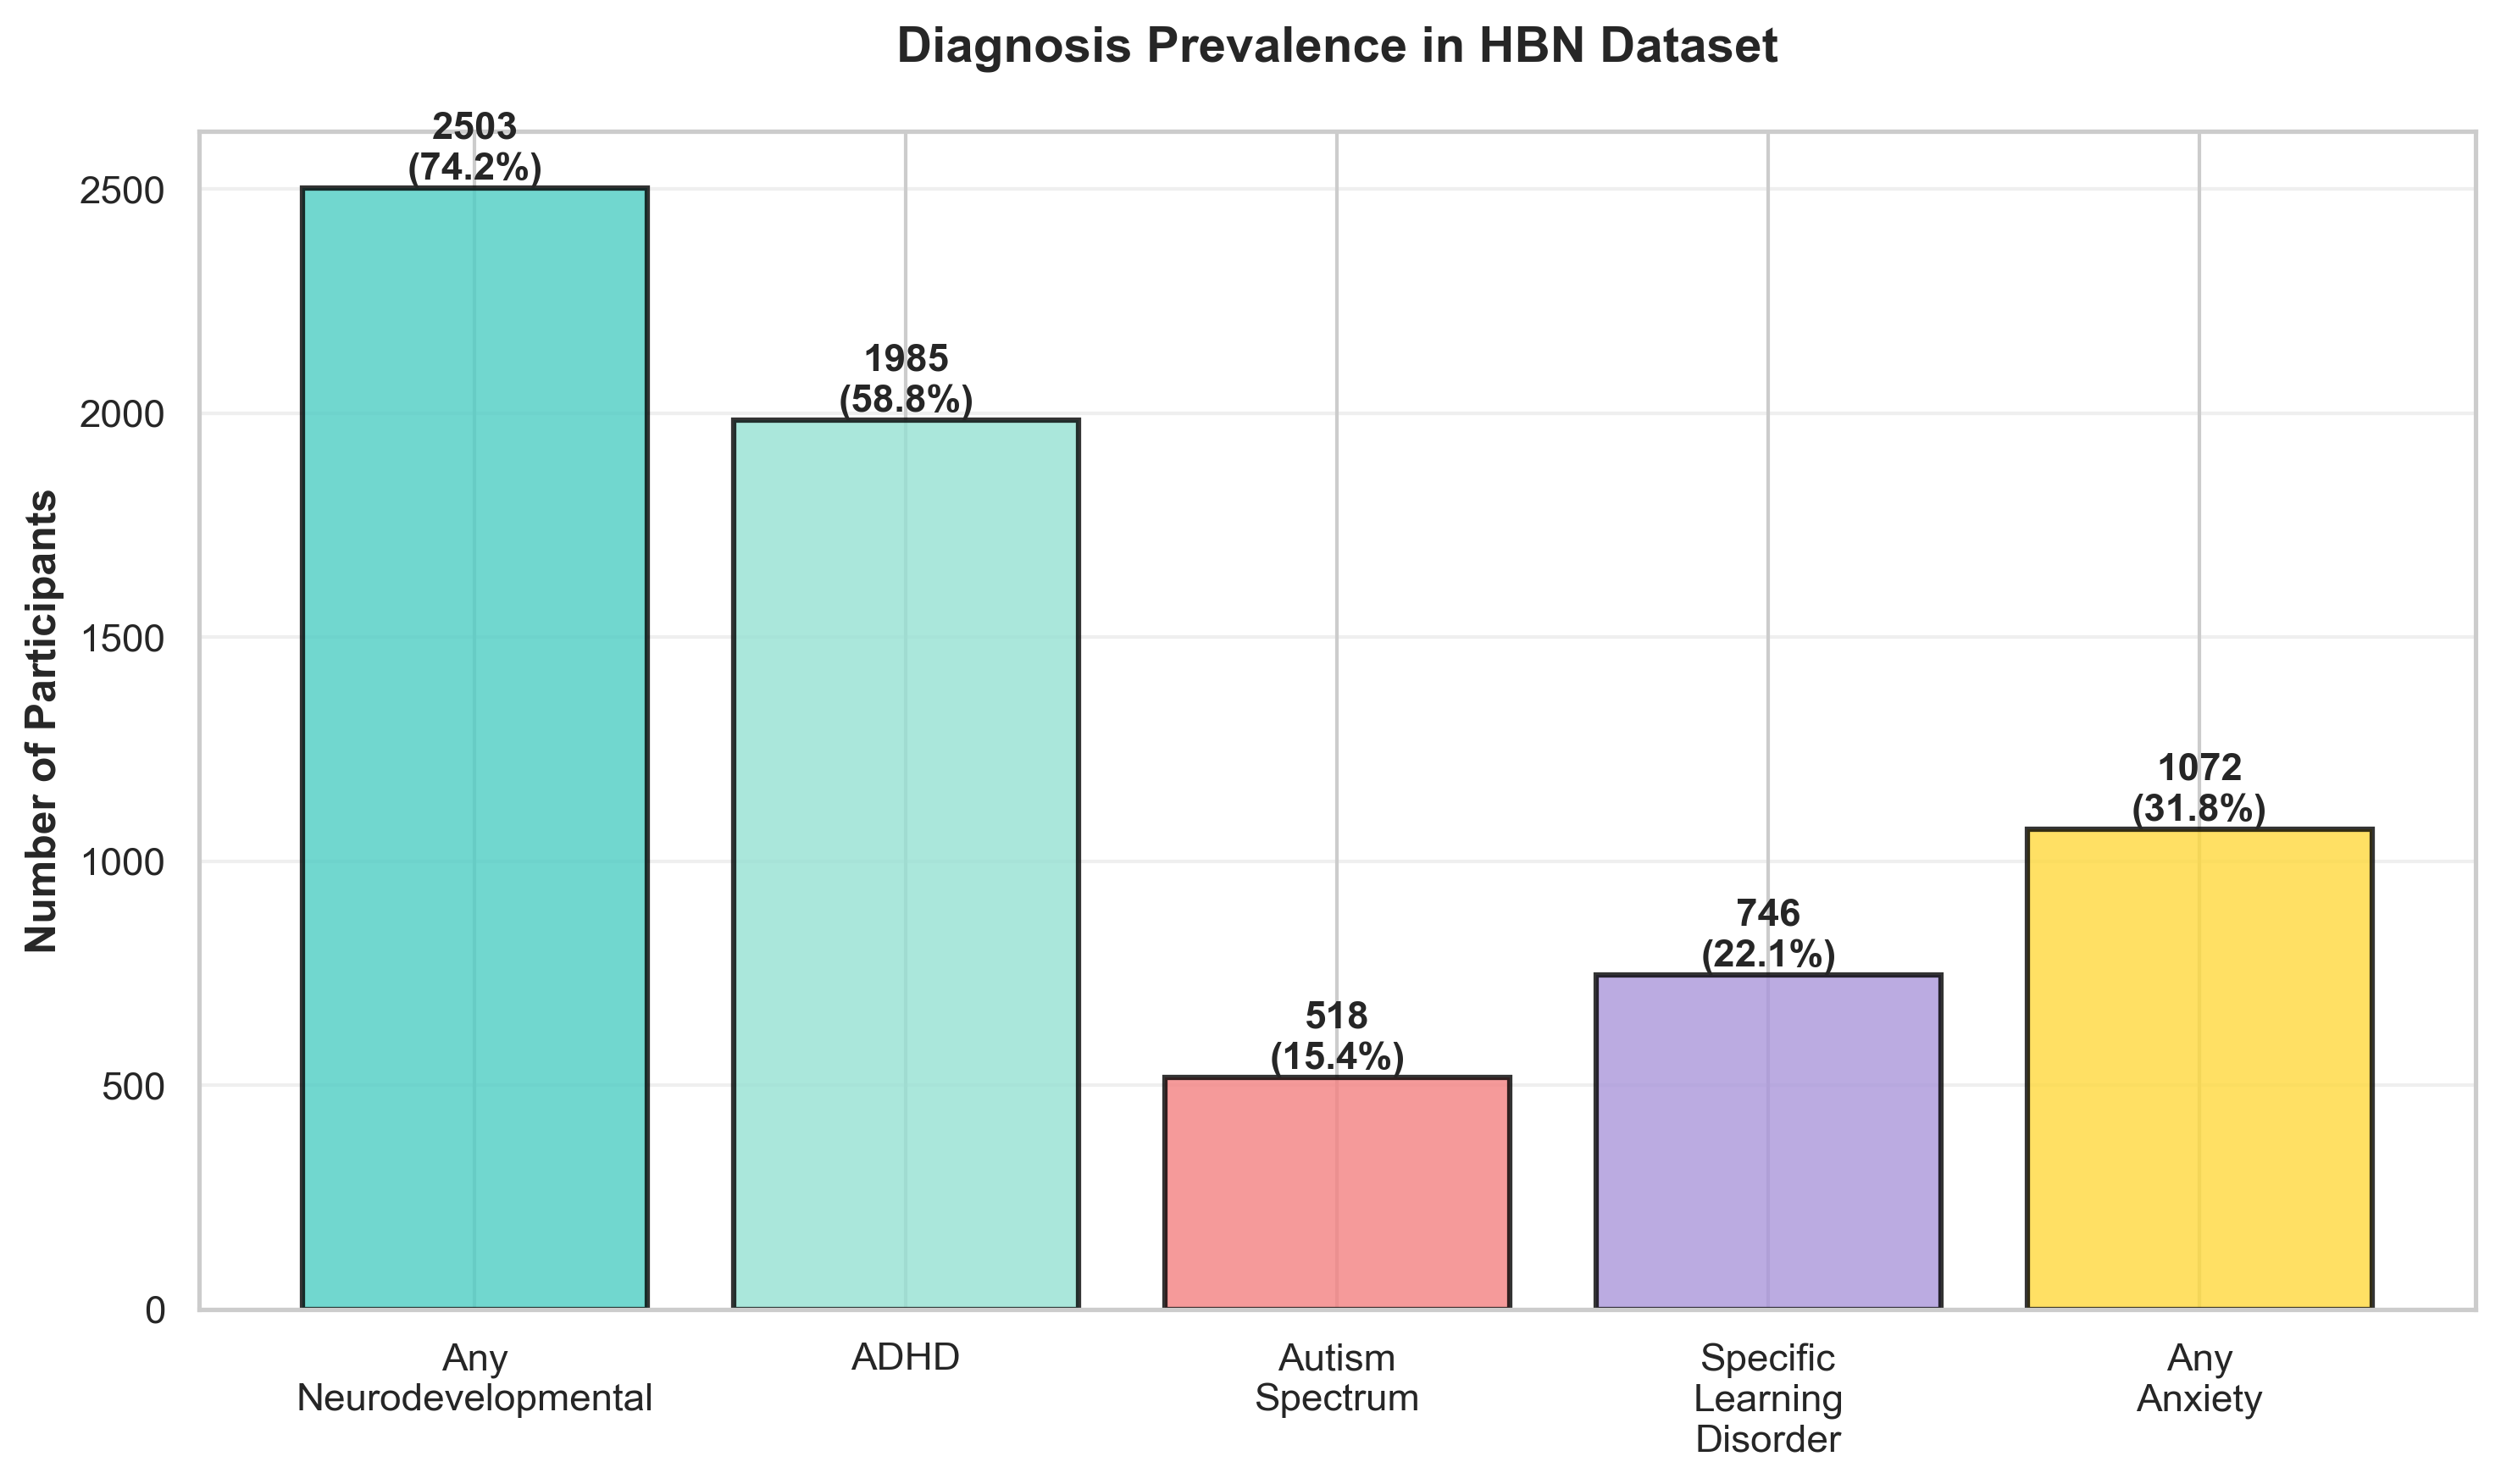

✓ Saved: diagnosis_prevalence.png


In [90]:
# Create prevalence bar chart
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

labels = [
    "Any\nNeurodevelopmental",
    "ADHD",
    "Autism\nSpectrum",
    "Specific\nLearning\nDisorder",
    "Any\nAnxiety"
]

colors_map = {
    "dx_neuro_any": "#4ECDC4",
    "dx_adhd_any": "#95E1D3",
    "dx_asd_any": "#F38181",
    "dx_sld_any": "#AA96DA",
    "dx_anx_any": "#FFD93D"
}

colors = [colors_map[col] for col in flag_cols]
counts = summary_stats["N"].values

bars = ax.bar(range(len(labels)), counts, color=colors, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, count, pct) in enumerate(zip(bars, counts, summary_stats["Prevalence_%"])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(count)}\n({pct:.1f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax.set_title('Diagnosis Prevalence in HBN Dataset', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "diagnosis_prevalence.png", 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: diagnosis_prevalence.png")

### 8.2 Comorbidity Heatmap

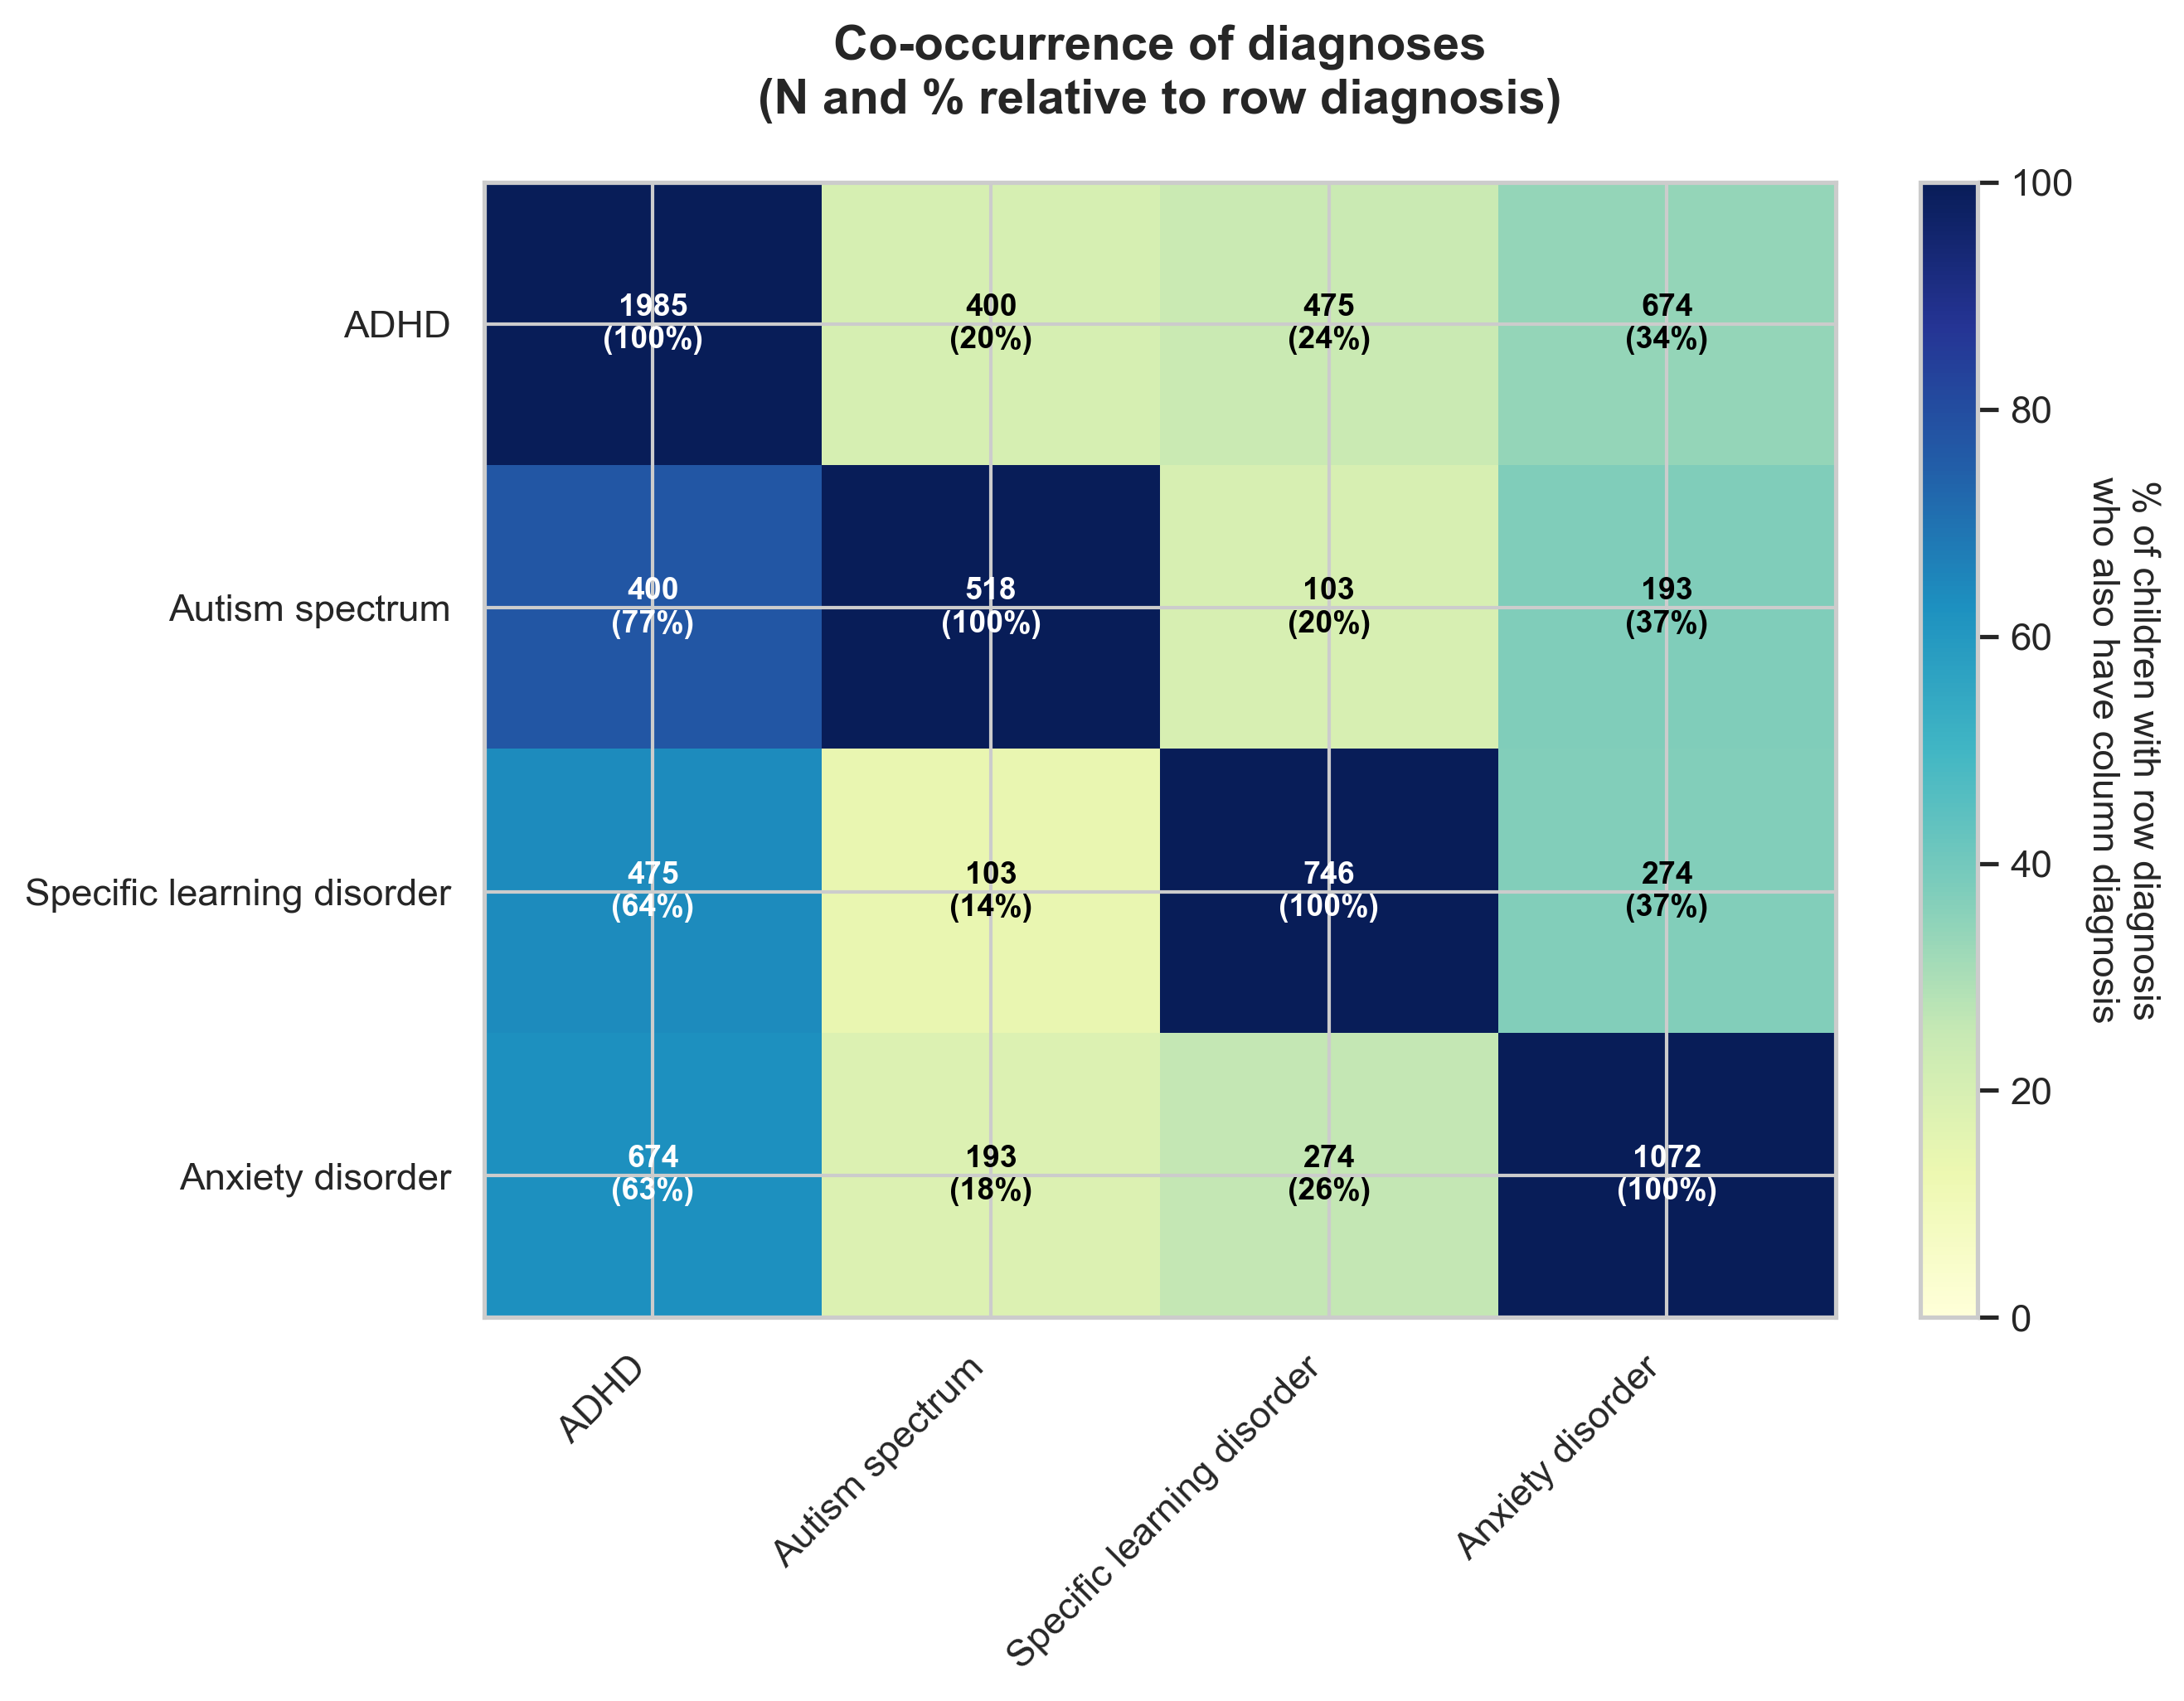

✓ Saved: diagnosis_comorbidity_heatmap.png


In [115]:
# === Diagnosis co-occurrence: counts and conditional percentages ===

flag_cols = ["dx_adhd_any", "dx_asd_any", "dx_sld_any", "dx_anx_any"]
nice_labels = ["ADHD", "Autism spectrum", "Specific learning disorder", "Anxiety disorder"]

flag_data = diag_flags[flag_cols].copy()
flag_data.columns = nice_labels

n_flags = len(nice_labels)

# 1) Co-occurrence counts: N with BOTH row and column diagnoses
cooccur = pd.DataFrame(
    np.zeros((n_flags, n_flags), dtype=int),
    index=nice_labels,
    columns=nice_labels,
)

for i, row_dx in enumerate(nice_labels):
    for j, col_dx in enumerate(nice_labels):
        cooccur.loc[row_dx, col_dx] = ((flag_data[row_dx] == 1) & (flag_data[col_dx] == 1)).sum()

# 2) Conditional %: among kids with row_dx, % who also have col_dx
perc = cooccur.astype(float)
for row_dx in nice_labels:
    row_total = cooccur.loc[row_dx, row_dx]  # N with row_dx
    if row_total > 0:
        perc.loc[row_dx, :] = cooccur.loc[row_dx, :] / row_total * 100.0
    else:
        perc.loc[row_dx, :] = 0.0

# 3) Plot heatmap of % with overlaid counts + %
fig, ax = plt.subplots(figsize=(9, 7), dpi=300)

im = ax.imshow(
    perc.values,
    cmap="YlGnBu",       # softer sequential palette
    aspect="auto",
    vmin=0,
    vmax=100,
)

# Axis ticks
ax.set_xticks(range(n_flags))
ax.set_yticks(range(n_flags))
ax.set_xticklabels(nice_labels, rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(nice_labels, fontsize=11)

# Text annotations: N and %
max_perc = np.nanmax(perc.values)
for i in range(n_flags):
    for j in range(n_flags):
        count = cooccur.iloc[i, j]
        pct = perc.iloc[i, j]
        text = f"{int(count)}\n({pct:.0f}%)"
        # Use white text on darker cells, black on lighter cells
        text_color = "white" if pct > max_perc * 0.6 else "black"
        ax.text(
            j, i,
            text,
            ha="center",
            va="center",
            color=text_color,
            fontweight="bold",
            fontsize=9,
        )

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(
    "% of children with row diagnosis\nwho also have column diagnosis",
    rotation=270,
    labelpad=25,
    fontsize=11,
)

ax.set_title(
    "Co-occurrence of diagnoses\n(N and % relative to row diagnosis)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
plt.savefig(
    RESULTS_DIR / "diagnosis_comorbidity_heatmap.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

print("✓ Saved: diagnosis_comorbidity_heatmap.png")

### 8.3 Venn Diagrams: Comorbidity

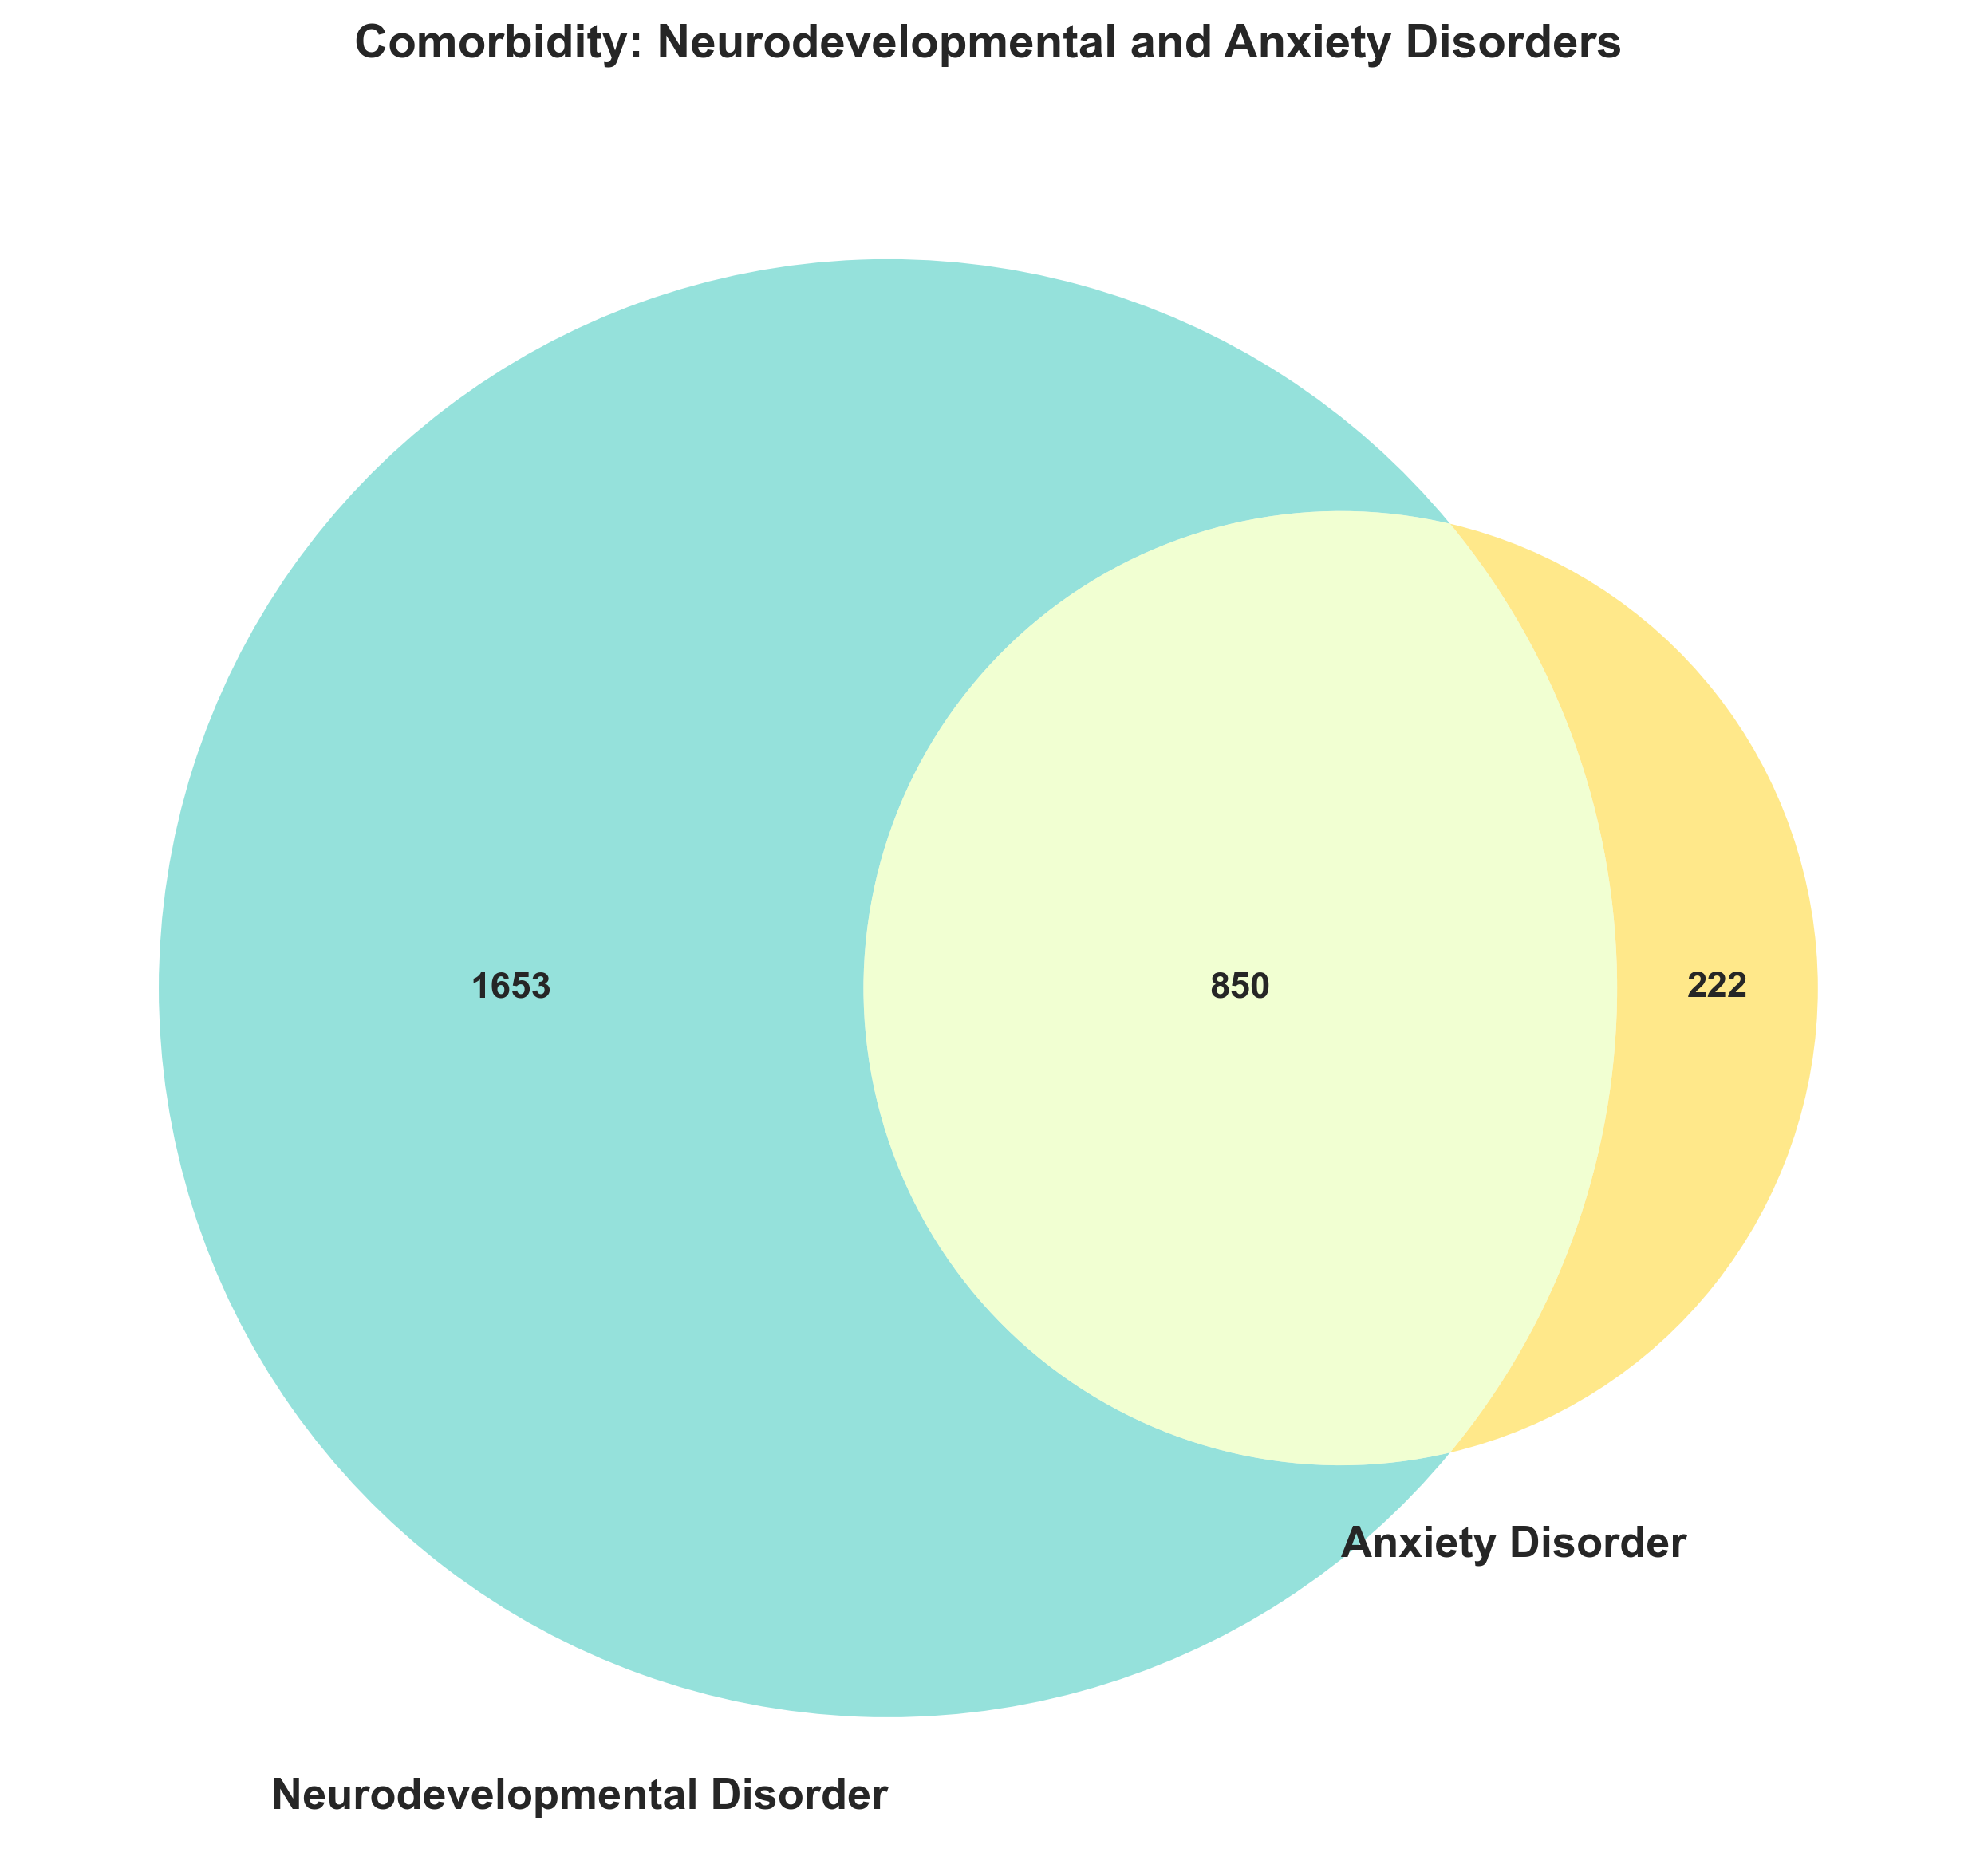

Saved Venn ND vs Anxiety to: results/diagnosis_figures/venn_neuro_vs_anx.png


In [104]:
# -------- Venn 1: ND vs Anxiety --------
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Get sets
nd_set  = set(diag_flags[diag_flags["dx_neuro_any"] == 1].index)
anx_set = set(diag_flags[diag_flags["dx_anx_any"]  == 1].index)

# Create Venn diagram
venn = venn2(
    [nd_set, anx_set],
    set_labels=("Neurodevelopmental Disorder", "Anxiety Disorder"),
    ax=ax,
    set_colors=("#4ECDC4", "#FFD93D"),
    alpha=0.6,
)

# Enhance labels
if venn.set_labels is not None:
    for text in venn.set_labels:
        if text:
            text.set_fontsize(13)
            text.set_fontweight("bold")

if venn.subset_labels is not None:
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(11)
            text.set_fontweight("bold")

ax.set_title(
    "Comorbidity: Neurodevelopmental and Anxiety Disorders",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
out_path = RESULTS_DIR / "venn_neuro_vs_anx.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"Saved Venn ND vs Anxiety to: {out_path}")

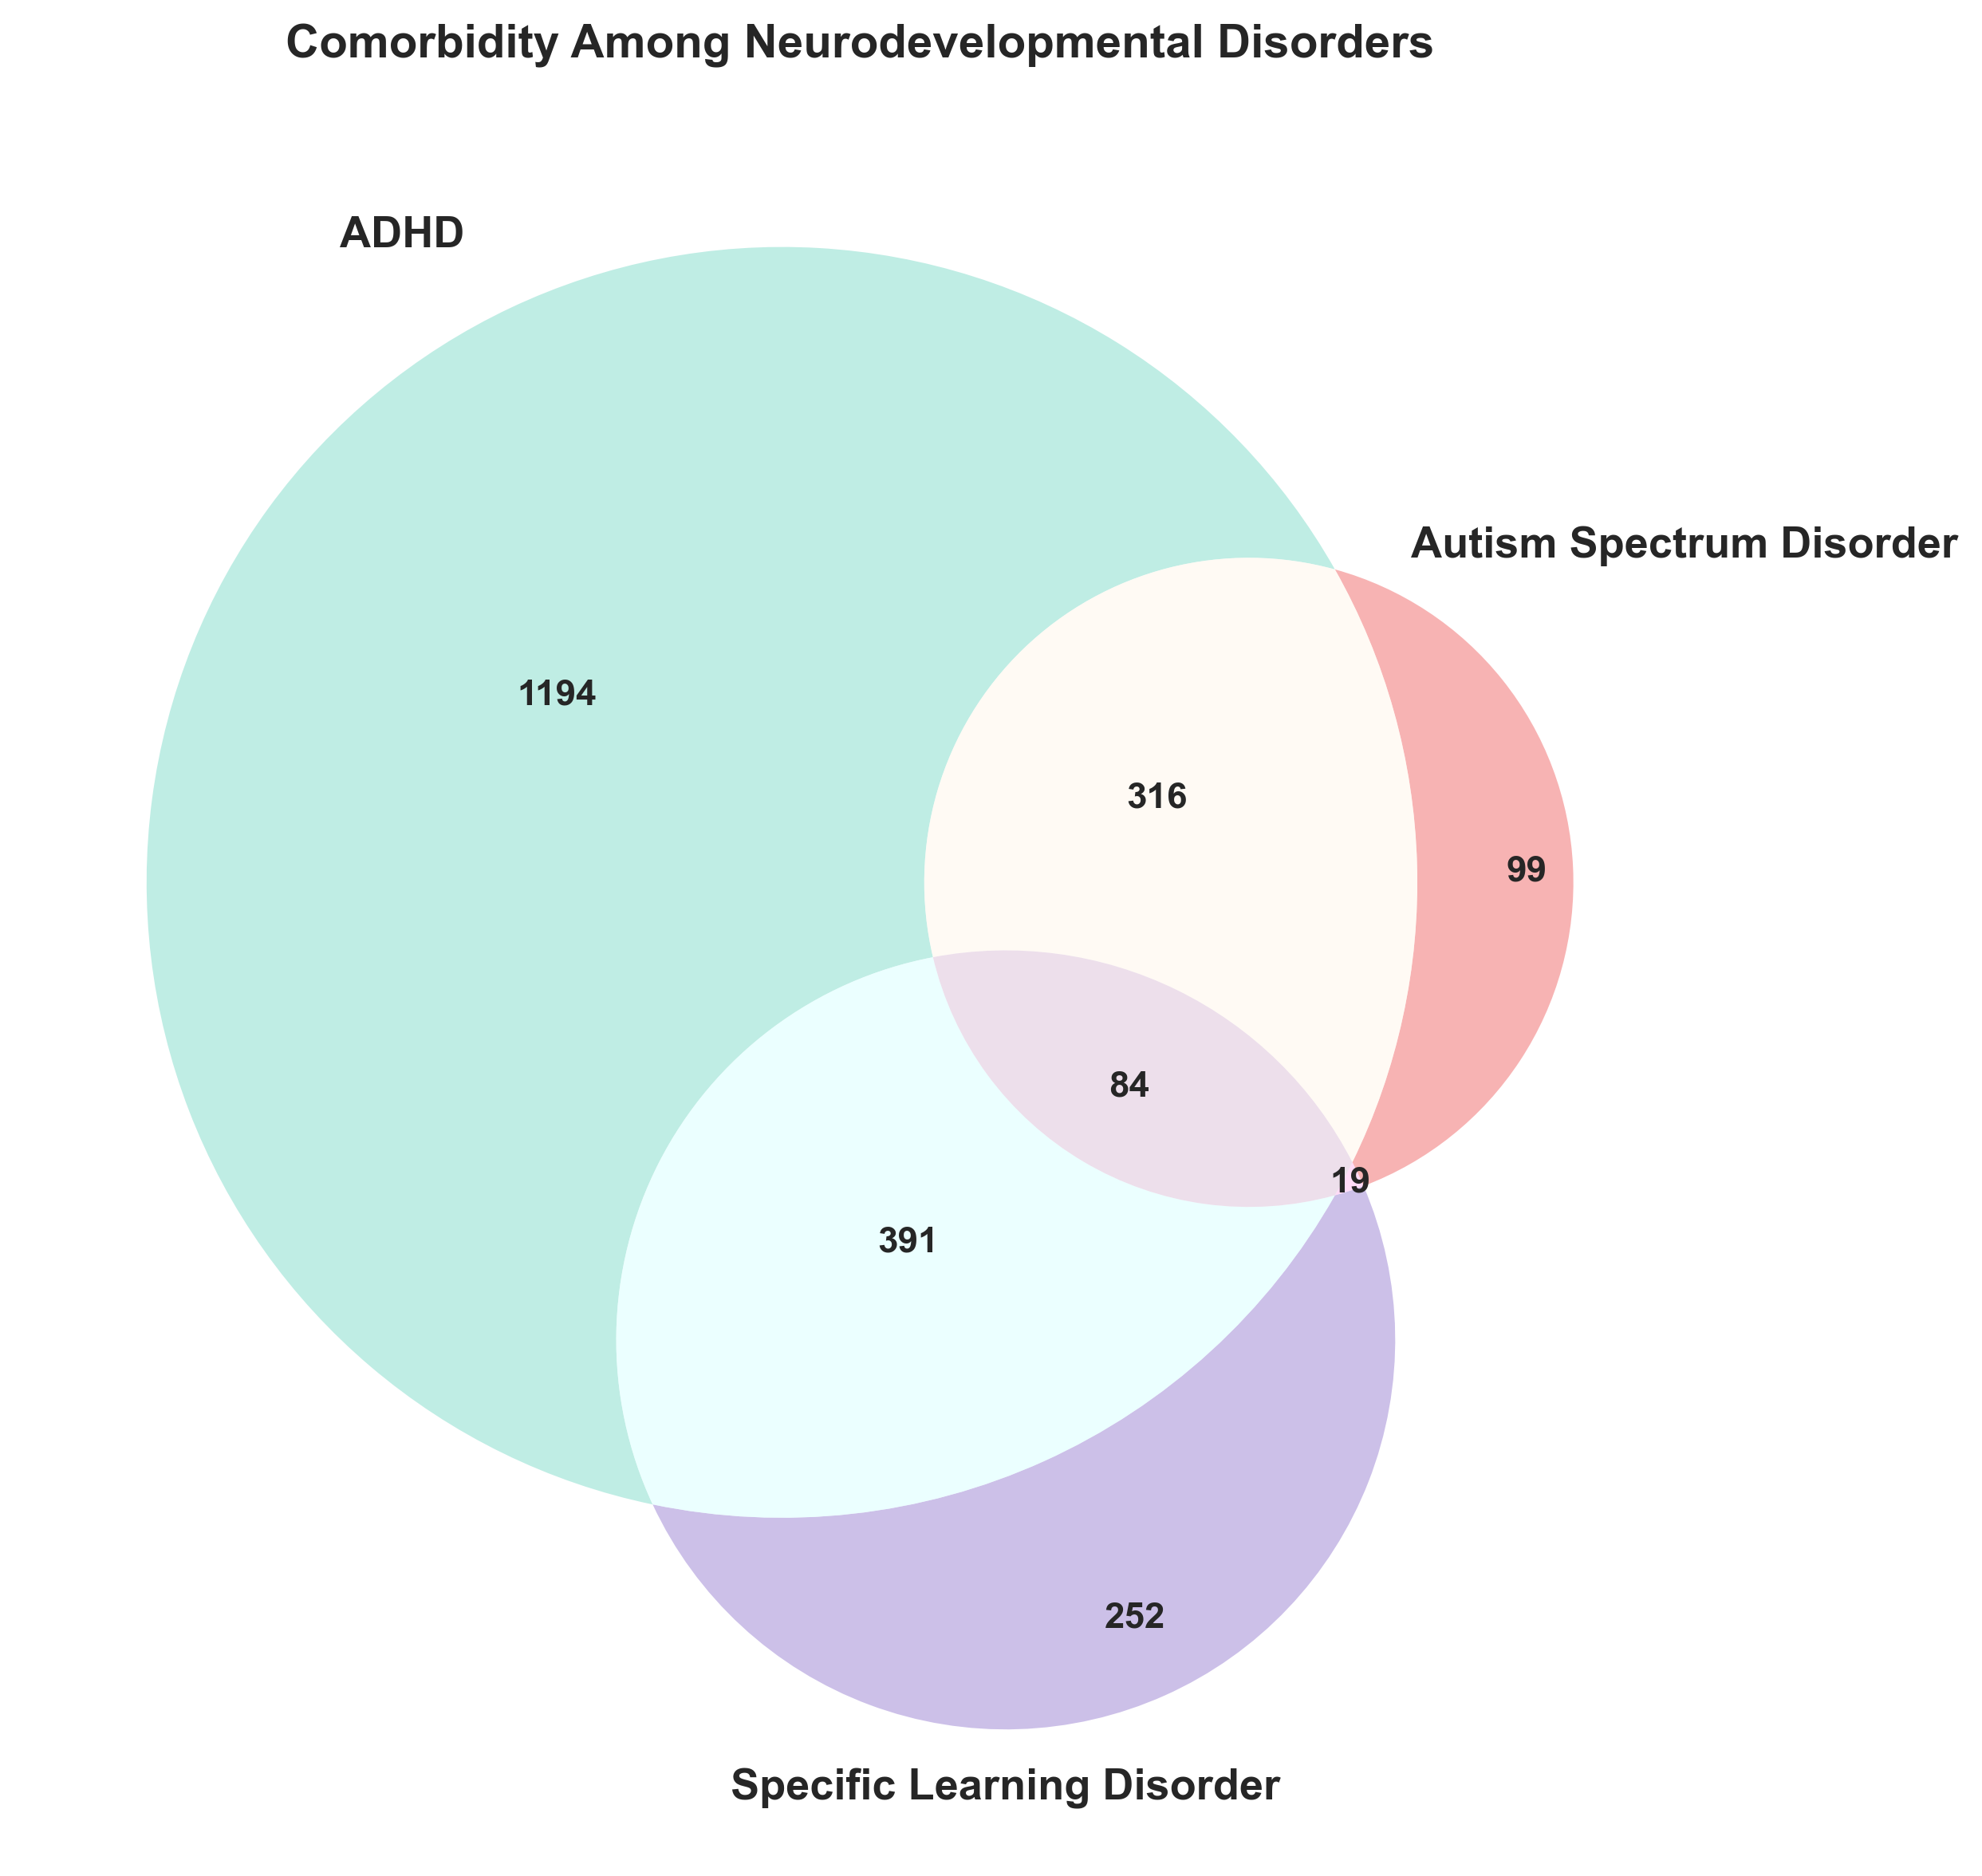

Saved Venn ADHD/ASD/SLD to: results/diagnosis_figures/venn_adhd_asd_sld.png


In [105]:
# -------- Venn 2: ADHD vs ASD vs SLD --------
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Get sets
adhd_set = set(diag_flags[diag_flags["dx_adhd_any"] == 1].index)
asd_set  = set(diag_flags[diag_flags["dx_asd_any"]  == 1].index)
sld_set  = set(diag_flags[diag_flags["dx_sld_any"]  == 1].index)

# Note: venn3 takes *three* sets, not four
venn = venn3(
    [adhd_set, asd_set, sld_set],
    set_labels=("ADHD", "Autism Spectrum Disorder", "Specific Learning Disorder"),
    ax=ax,
    set_colors=("#95E1D3", "#F38181", "#AA96DA"),
    alpha=0.6,
)

# Enhance labels
if venn.set_labels is not None:
    for text in venn.set_labels:
        if text:
            text.set_fontsize(13)
            text.set_fontweight("bold")

if venn.subset_labels is not None:
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(11)
            text.set_fontweight("bold")

ax.set_title(
    "Comorbidity Among Neurodevelopmental Disorders",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
out_path = RESULTS_DIR / "venn_adhd_asd_sld.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"Saved Venn ADHD/ASD/SLD to: {out_path}")

### 8.4 Diagnosis Slot Utilization

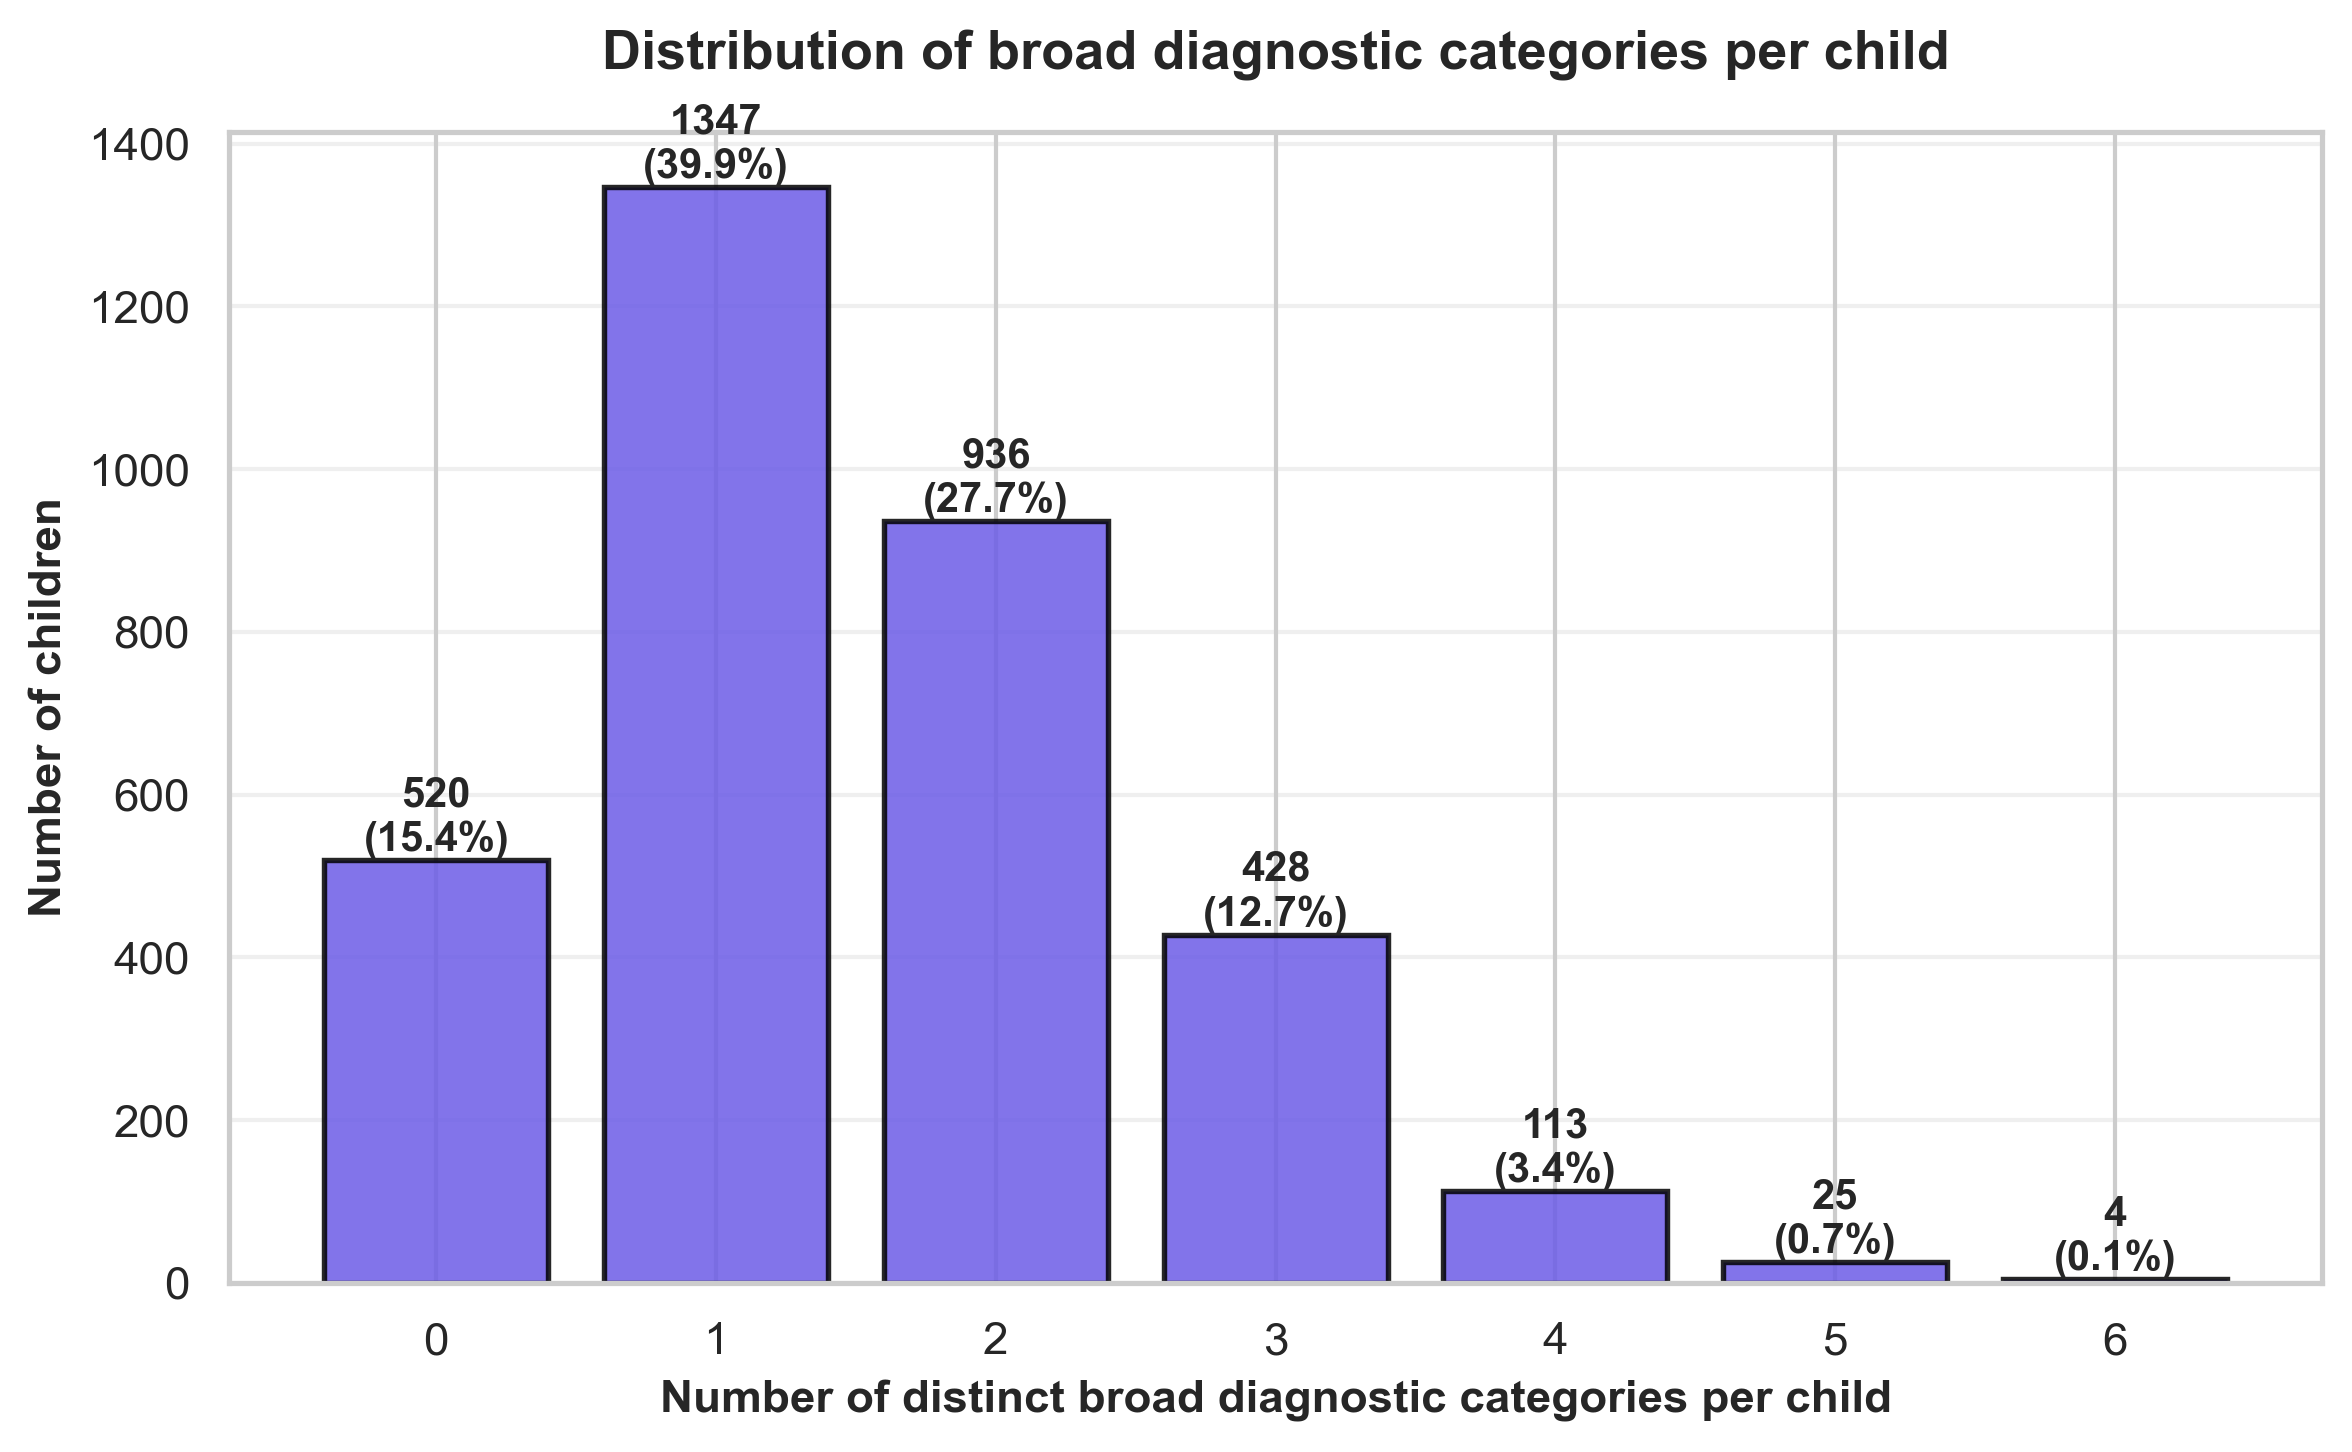

✓ Saved: diagnostic_families_per_child.png


In [113]:
# === Distinct broad diagnostic categories per child ===

# Broad category columns: dx_cat_cols already defined earlier
# diag: clinician-consensus diagnosis table, one row per child

excluded_cats = {
    "No Diagnosis Given",
    "No Diagnosis Given: Incomplete Eval",
    "Other Conditions That May Be a Focus of Clinical Attention",
}

# Copy the category table
cats = diag[dx_cat_cols].copy()

# Replace excluded categories with NaN so they don't count
cats = cats.mask(cats.isin(excluded_cats))

# For each child: how many *distinct* broad categories (across all slots)?
n_families = cats.nunique(axis=1, dropna=True)

# Distribution: how many children have 0, 1, 2, ... broad categories?
fam_dist = n_families.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

bars = ax.bar(
    fam_dist.index,
    fam_dist.values,
    color="#6C5CE7",
    alpha=0.85,
    edgecolor="black",
    linewidth=1.3,
)

# Add counts + % of children above each bar
N_children = len(diag)
for bar in bars:
    height = bar.get_height()
    k = int(bar.get_x() + bar.get_width() / 2)  # number of categories
    pct = height / N_children * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Number of distinct broad diagnostic categories per child",
              fontsize=11, fontweight="bold")
ax.set_ylabel("Number of children", fontsize=11, fontweight="bold")
ax.set_title("Distribution of broad diagnostic categories per child",
             fontsize=13, fontweight="bold", pad=15)

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xticks(range(int(fam_dist.index.max()) + 1))

plt.tight_layout()
plt.savefig(
    RESULTS_DIR / "diagnostic_families_per_child.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

print("✓ Saved: diagnostic_families_per_child.png")

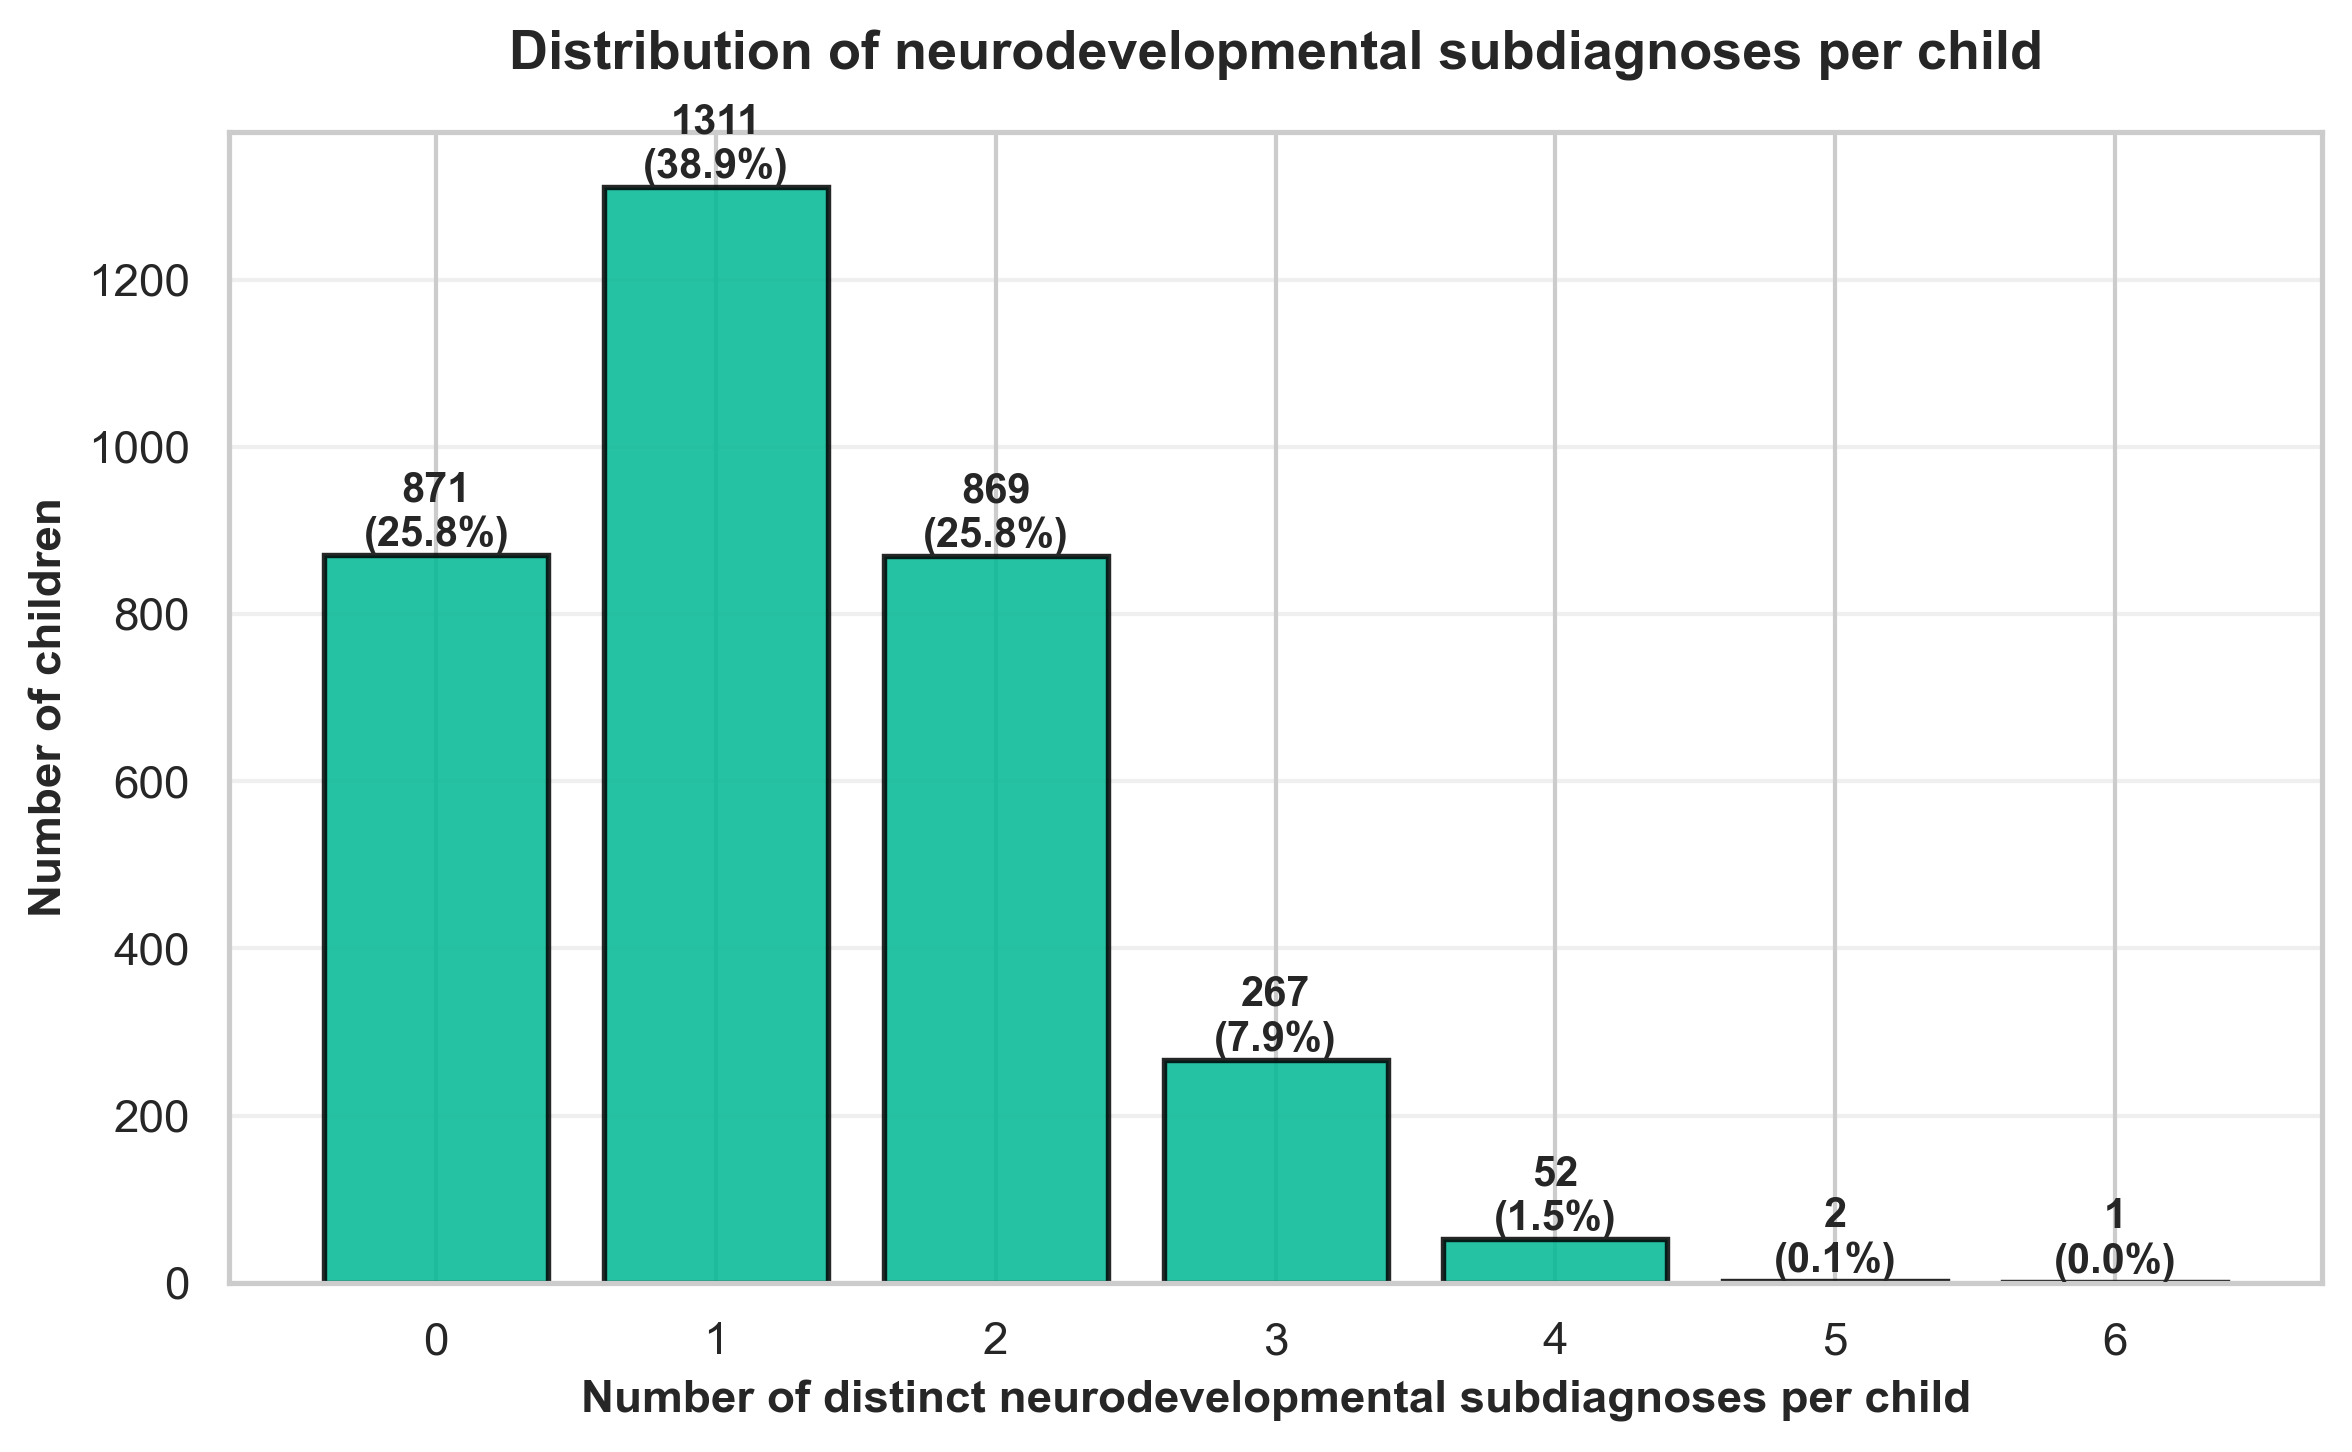

✓ Saved: nd_subdiagnoses_per_child.png


In [114]:
# === Distinct neurodevelopmental subdiagnoses per child ===

# We'll build a wide table where each column is the ND subdiagnosis from one slot
# (or NaN if that slot isn't Neurodevelopmental Disorders)

nd_subs = pd.DataFrame(index=diag.index)

for cat_col in dx_cat_cols:
    # Find corresponding Sub column for this slot
    slot_suffix = "_Cat"
    if not cat_col.endswith(slot_suffix):
        continue
    sub_col = cat_col.replace("_Cat", "_Sub")
    if sub_col not in diag.columns:
        continue
    
    # Keep Sub only if Cat == "Neurodevelopmental Disorders", else NaN
    nd_subs[sub_col] = np.where(
        diag[cat_col] == "Neurodevelopmental Disorders",
        diag[sub_col],
        np.nan,
    )

# For each child: number of DISTINCT ND subdiagnoses (ADHD, ASD, SLD, etc.)
n_nd_subs = nd_subs.nunique(axis=1, dropna=True)

# Distribution: how many children have 0, 1, 2, 3+ ND subdiagnoses?
nd_dist = n_nd_subs.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

bars = ax.bar(
    nd_dist.index,
    nd_dist.values,
    color="#00B894",
    alpha=0.85,
    edgecolor="black",
    linewidth=1.3,
)

N_children = len(diag)
for bar in bars:
    height = bar.get_height()
    k = int(bar.get_x() + bar.get_width() / 2)
    pct = height / N_children * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Number of distinct neurodevelopmental subdiagnoses per child",
              fontsize=11, fontweight="bold")
ax.set_ylabel("Number of children", fontsize=11, fontweight="bold")
ax.set_title("Distribution of neurodevelopmental subdiagnoses per child",
             fontsize=13, fontweight="bold", pad=15)

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xticks(range(int(nd_dist.index.max()) + 1))

plt.tight_layout()
plt.savefig(
    RESULTS_DIR / "nd_subdiagnoses_per_child.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

print("✓ Saved: nd_subdiagnoses_per_child.png")

### 8.5 Top Diagnostic Categories (All Slots)

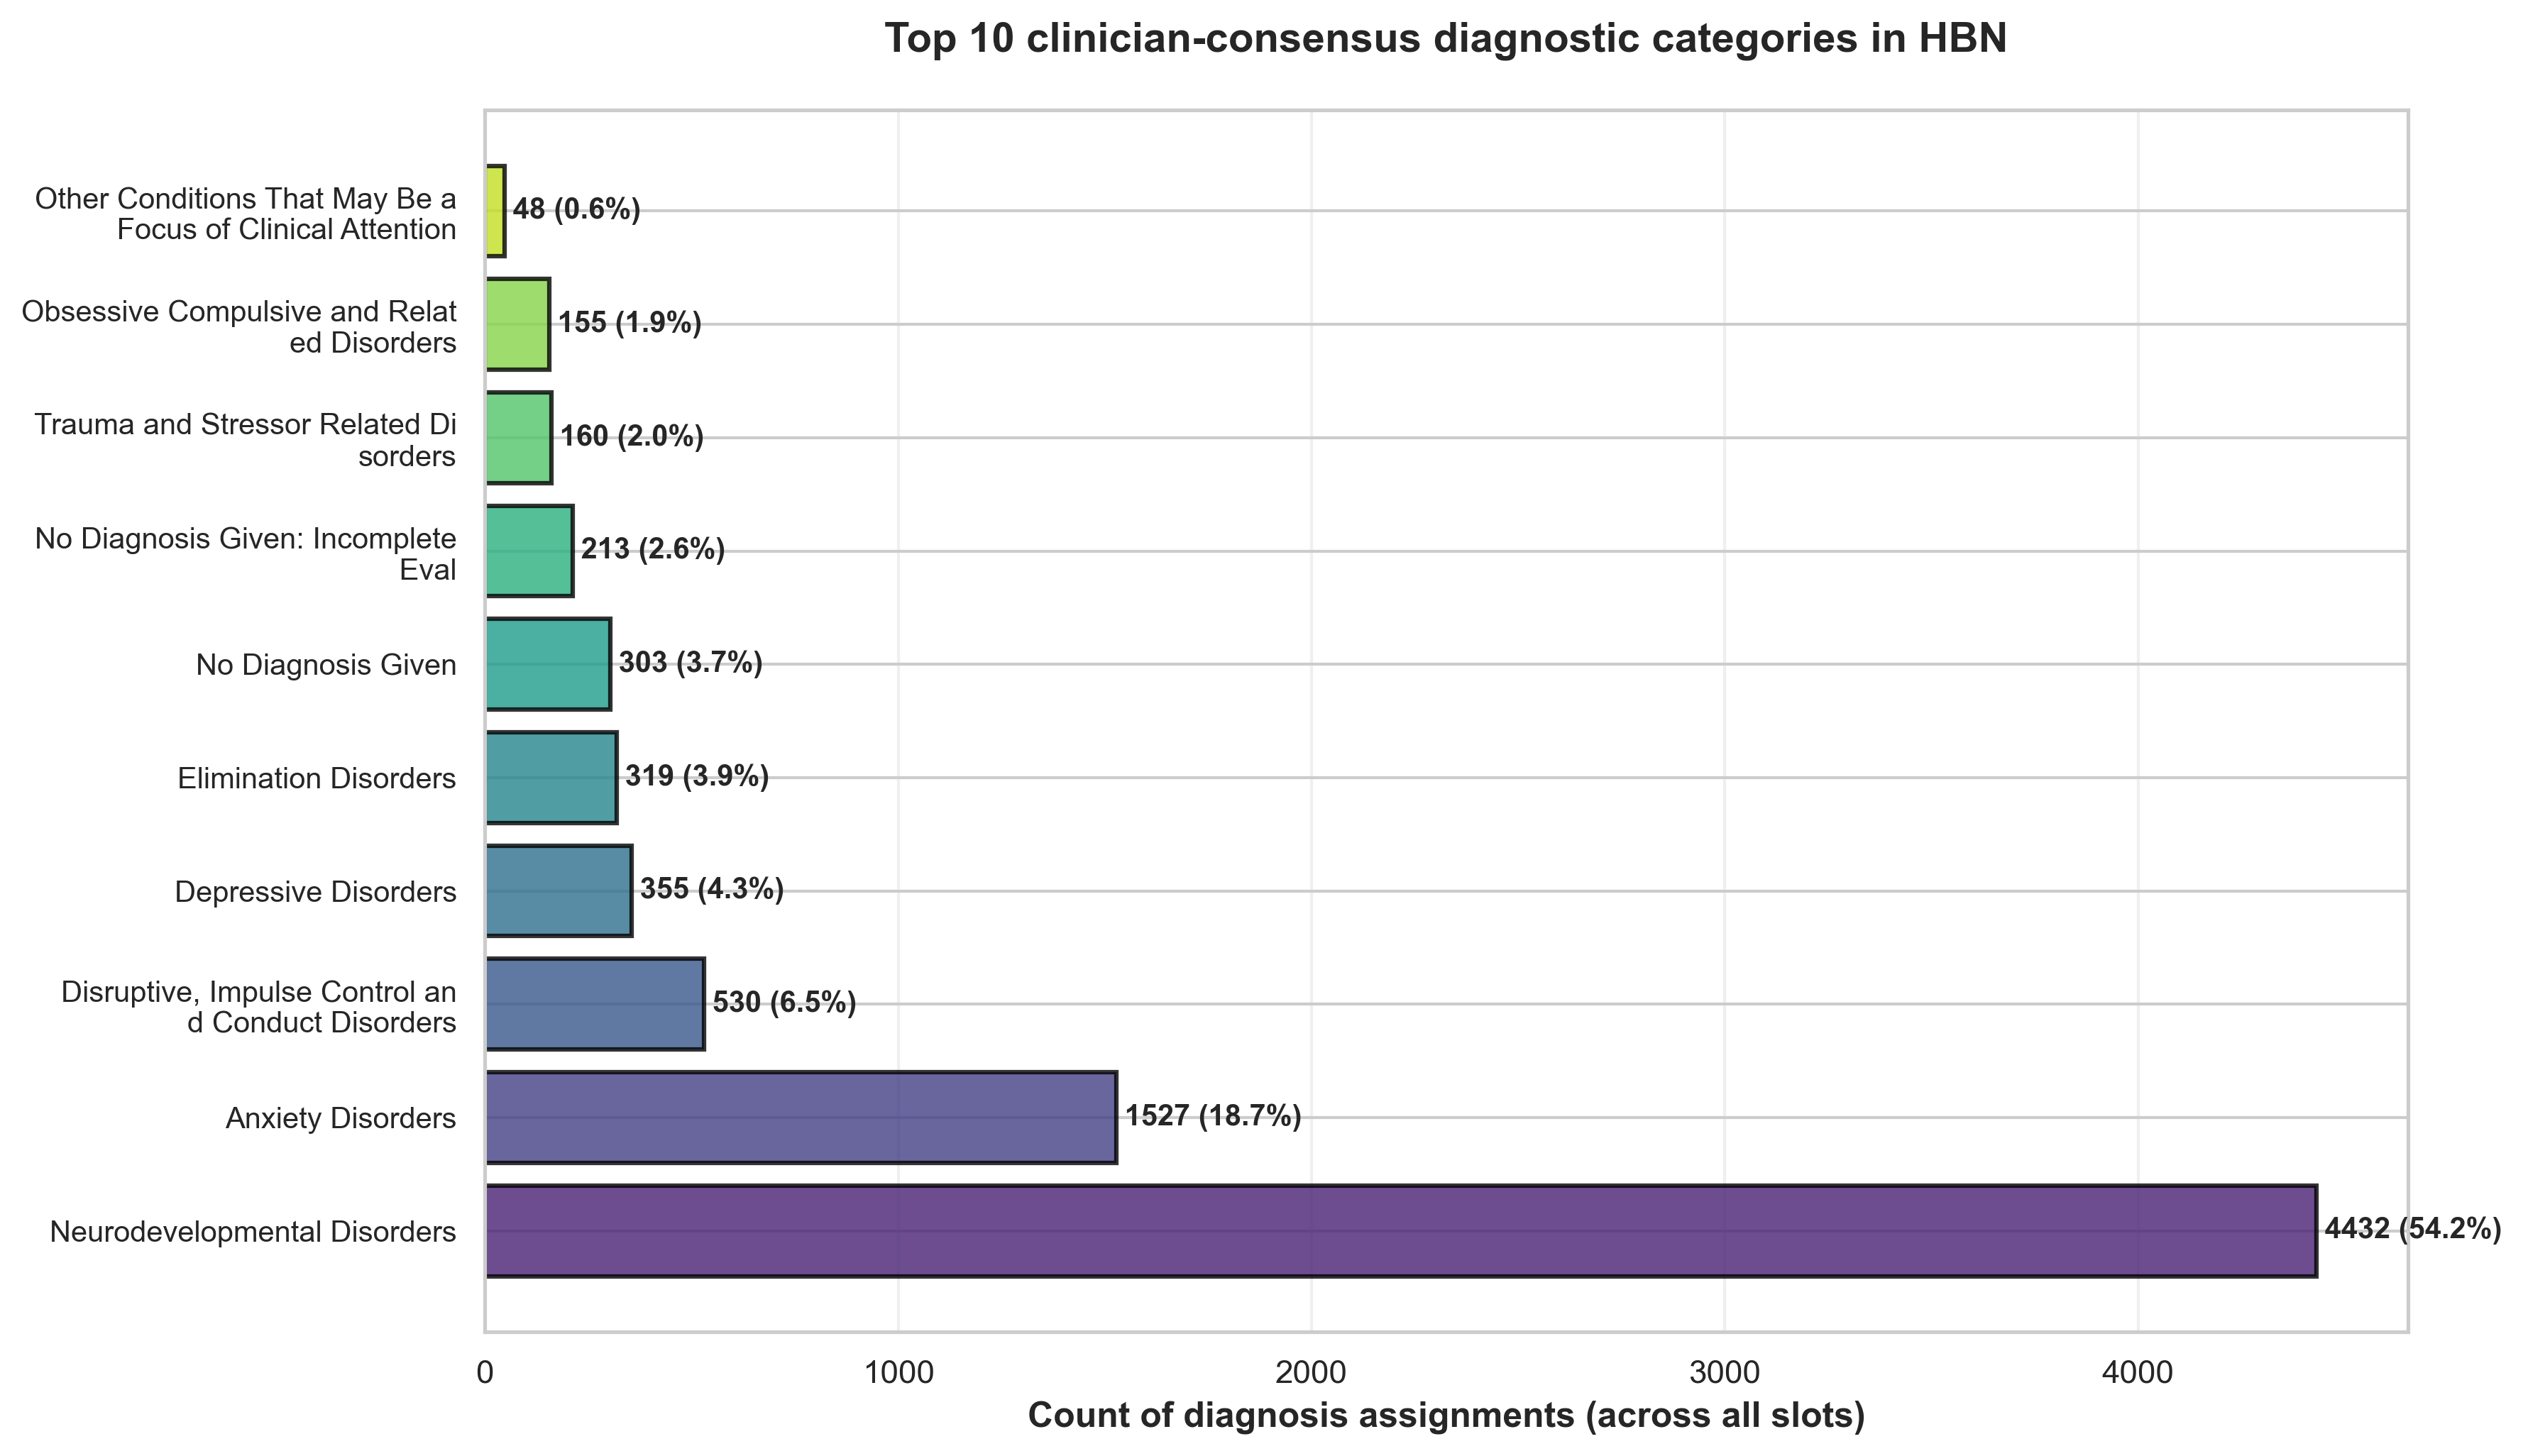

✓ Saved: top_diagnostic_categories.png


In [111]:
# - `diag` is the clinician-consensus diagnosis table
# - `dx_cat_cols` are the category columns
# - `cat_counts` was computed as:
#     all_cats = pd.concat([diag[col].dropna() for col in dx_cat_cols], ignore_index=True)
#     cat_counts = all_cats.value_counts()

# Take the top 10 most frequent broad categories
top_cats = cat_counts.head(10)

fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

# Horizontal bar positions
y_pos = range(len(top_cats))

# Bar chart of counts of diagnosis assignments
bars = ax.barh(
    y_pos,
    top_cats.values,
    color=sns.color_palette('viridis', len(top_cats)),
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

# Total number of diagnosis assignments across all slots
total_assignments = cat_counts.sum()

# Add value labels: count + % of all assignments
for bar, count in zip(bars, top_cats.values):
    width = bar.get_width()
    pct = count / total_assignments * 100.0   # % of diagnosis assignments
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2.0,
        f' {int(count)} ({pct:.1f}%)',
        ha='left',
        va='center',
        fontweight='bold',
        fontsize=10
    )

# Wrap long labels at ~30 characters for readability
wrapped_labels = [
    '\n'.join([name[i:i+30] for i in range(0, len(name), 30)])
    for name in top_cats.index
]

ax.set_yticks(list(y_pos))
ax.set_yticklabels(wrapped_labels, fontsize=10)

ax.set_xlabel(
    'Count of diagnosis assignments (across all slots)',
    fontsize=12,
    fontweight='bold'
)
ax.set_title(
    'Top 10 clinician-consensus diagnostic categories in HBN',
    fontsize=14,
    fontweight='bold',
    pad=20
)

ax.grid(True, alpha=0.3, axis='x')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(
    RESULTS_DIR / "top_diagnostic_categories.png",
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)
plt.show()

print("✓ Saved: top_diagnostic_categories.png")

## 9. Summary

### Files Created

**Data:**
- `data/processed/hbn_diag_flags_neuro_anx.csv` - Binary diagnosis flags

**Figures (300 DPI):**
- `diagnosis_prevalence.png` - Prevalence bar chart
- `diagnosis_comorbidity_heatmap.png` - Co-occurrence matrix
- `diagnosis_venn_adhd_asd_anx.png` - Venn diagram of key diagnoses
- `diagnosis_count_distribution.png` - Number of diagnoses per participant
- `top_diagnostic_categories.png` - Most common categories

### Key Findings

1. **Primary Diagnosis Categories:**
   - Neurodevelopmental disorders: Most common
   - ADHD: Most prevalent specific diagnosis
   - Anxiety disorders: Second major category

2. **Data Structure:**
   - Most participants have 1-2 diagnoses
   - Later diagnosis slots (DX_03+) mostly empty
   - Subcategories well-populated for Neurodevelopmental, sparse for Anxiety

3. **Comorbidity:**
   - Substantial overlap between ADHD and Anxiety
   - Less overlap between ASD and other conditions
   - Multiple diagnoses common in clinical sample

In [95]:
print(f"\n Diagnosis flags: {out_path}")
print(f"   • {len(diag_flags)} participants")
print(f"   • {len(flag_cols)} diagnosis flags")
print(f"\n Figures: {RESULTS_DIR}")


 Diagnosis flags: data/processed/hbn_diag_flags_neuro_anx.csv
   • 3373 participants
   • 5 diagnosis flags

 Figures: results/diagnosis_figures
